In [98]:
import pandas
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, "src")
import dataset
import config

%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# To be moved into utils
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(folder, file, url):
    data_path = os.path.join(folder, file)

    if not os.path.exists(folder):
        os.makedirs(folder)

    if os.path.exists(folder):
        print(f"Downloading SKA {file} data...")
        with requests.Session() as current_session:
            response = current_session.get(url, stream=True)
        save_response_content(response, data_path)
        print("Download completed!")
if false:
    download_data('data/training', 'training_SKA.txt', "https://owncloud.ia2.inaf.it/index.php/s/iTOVkIL6EfXkcdR/download") #54Mb
    download_data('data/training', 'PrimaryBeam_B1.fits', 'https://owncloud.ia2.inaf.it/index.php/s/ZbaSDe7zGBYgxL1/download') #300Kb
    download_data('data/training', 'SynthesBeam_B1.fits', 'https://owncloud.ia2.inaf.it/index.php/s/cwzf1BO2pyg9TVv/download')#4Gb


Download completed!
Download completed!
Download completed!


In [17]:
DATA_FOLDER = os.path.join(os.getcwd(), "data")
TRAIN_DATA_FOLDER = os.path.join(DATA_FOLDER, "training")
TRAIN_SET_PATH = os.path.join(TRAIN_DATA_FOLDER, "training_SKA.txt")

In [97]:
# Dataset parsing and loading
# use "subset" to load a small portion of data for development/debugging purposes

ska_dataset = dataset.SKADataset(train_set_path=TRAIN_SET_PATH, subset=config.DATA_SUBSET)
print(ska_dataset.raw_train_df.shape)
ska_dataset.raw_train_df.head()

(27488, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,22923268,-0.469784,-29.846916,-0.469784,-29.846916,4.579590e-08,-0.0,0.047,0.034,47.585,2,3,0,18810.611,17290.068
1,21867980,-0.359950,-29.521645,-0.359950,-29.521645,5.745240e-08,-0.0,0.109,0.070,-15.109,2,3,0,18249.082,19229.991
2,25939522,-0.136767,-29.718441,-0.136767,-29.718441,9.155150e-07,-0.0,0.803,0.346,4.256,2,3,1,17090.657,18060.048
3,16617483,-0.133707,-29.543222,-0.133707,-29.543222,3.988710e-07,-0.0,0.199,0.095,-78.420,2,3,1,17076.029,19103.965
4,26912919,-0.064092,-29.847477,-0.064092,-29.847477,7.125110e-07,-0.0,0.113,0.064,-64.996,2,3,1,16714.196,17291.611


In [2]:
from astropy.io import fits

prim_beam = fits.open('./data/training/PrimaryBeam_B1.fits')
prim_beam.info()
pb = prim_beam[0].data[0,0]

Filename: ./training/PrimaryBeam_B1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     159   (257, 257, 1, 1)   float32   


In [3]:
print(pb.shape)
pb[100]

(257, 257)


array([9.15310229e-05, 7.49881510e-05, 6.15398167e-05, 5.25447176e-05,
       4.89711565e-05, 5.16506916e-05, 6.09772833e-05, 7.69881735e-05,
       9.91463166e-05, 1.26503452e-04, 1.57670846e-04, 1.90888328e-04,
       2.24196745e-04, 2.55429506e-04, 2.82468507e-04, 3.03413195e-04,
       3.16616672e-04, 3.20909807e-04, 3.15596437e-04, 3.00800952e-04,
       2.77315616e-04, 2.46599520e-04, 2.10763770e-04, 1.72403656e-04,
       1.34838076e-04, 1.01206489e-04, 7.45286961e-05, 5.75878112e-05,
       5.30903781e-05, 6.27023692e-05, 8.75258702e-05, 1.27861131e-04,
       1.82893171e-04, 2.50644196e-04, 3.28158552e-04, 4.11522982e-04,
       4.96227760e-04, 5.77440136e-04, 6.50169095e-04, 7.09450338e-04,
       7.50561827e-04, 7.70990737e-04, 7.68425292e-04, 7.42117234e-04,
       6.92806323e-04, 6.23322325e-04, 5.37287269e-04, 4.40409232e-04,
       3.39267164e-04, 2.41701695e-04, 1.56837021e-04, 9.29477101e-05,
       5.88580006e-05, 5.92225115e-05, 9.99376789e-05, 1.84903038e-04,
      

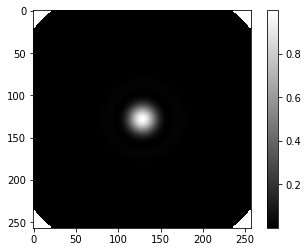

In [4]:
plt.imshow(pb, cmap='gray')
plt.colorbar()

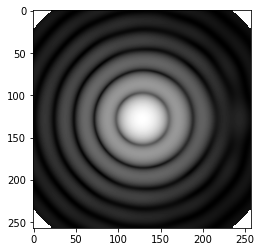

In [5]:
from matplotlib.colors import LogNorm

plt.imshow(pb, cmap='gray', norm=LogNorm()) # si vedono gli altri lobi

In [7]:
synth_beam = fits.open('./data/training/SynthesBeam_B1.fits')
synth_beam.info()
print(synth_beam[0].data)
print(synth_beam[0].data.shape)

Filename: ./training/SynthesBeam_B1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     106   (32768, 32768, 1)   float32   
[[[-4.6092705e-06  7.9404177e-05  6.6267850e-05 ... -5.9360613e-05
    6.6261659e-05  7.9413221e-05]
  [-1.7601602e-05  7.5226861e-05 -5.3575870e-05 ...  1.2435691e-04
    1.4492635e-04  2.4727831e-05]
  [-4.6314373e-05  4.4028919e-05 -1.1286519e-04 ...  5.9568585e-05
    5.5907949e-05 -5.9639624e-05]
  ...
  [-3.5801291e-05 -7.7079269e-05 -6.0392587e-05 ... -1.2557233e-04
   -7.6502656e-05  4.0111754e-05]
  [-3.4344663e-05 -5.0508614e-05  5.9718001e-05 ... -1.8035575e-04
   -1.0529848e-04  5.5156448e-05]
  [-3.3896584e-05  6.3543889e-06  1.2978740e-04 ... -2.0927859e-04
   -6.5564862e-05  6.4681102e-05]]]
(1, 32768, 32768)


In [8]:
data = synth_beam[0].data[0]
data.shape

(32768, 32768)

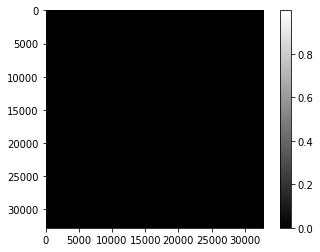

In [9]:
plt.imshow(data, cmap='gray')
plt.colorbar()

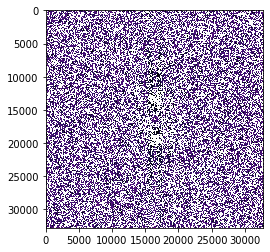

In [11]:
plt.imshow(data, cmap='magma', norm=LogNorm())

In [58]:
download_data('data/training', '560Mhz_1000h.fits', 'https://owncloud.ia2.inaf.it/index.php/s/hbasFhd4YILNkCr/download')#4Gb

Download completed!


In [59]:
data_560Mhz_1000h = fits.open('./data/training/560Mhz_1000h.fits')
data_560Mhz_1000h.info()
print(data_560Mhz_1000h[0].data)
print(data_560Mhz_1000h[0].data.shape)

Filename: ./training/560Mhz_1000h.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     118   (32768, 32768, 1, 1)   float32   
[[[[ 7.1060640e-07  9.4488450e-07  1.1032769e-06 ... -6.8421957e-07
    -2.8194003e-07  5.0735156e-07]
   [-8.7393175e-07 -5.6742880e-07  2.0195188e-07 ... -7.4518215e-07
    -5.5282339e-07 -6.4916463e-07]
   [-1.0181133e-06 -7.5760084e-07  7.4448522e-08 ...  3.0707969e-07
     1.1103984e-07 -6.1064839e-07]
   ...
   [-2.3913432e-07 -1.8789430e-07 -7.4891926e-07 ... -4.9300226e-08
     7.6338370e-07  1.9008338e-07]
   [ 8.9421593e-07  9.6105100e-07  2.4447789e-07 ...  1.3803012e-07
     4.9793789e-07  6.9441251e-07]
   [ 1.5291014e-06  1.6155885e-06  1.0907955e-06 ...  2.5894280e-08
     2.7655841e-07  1.1393061e-06]]]]
(1, 1, 32768, 32768)


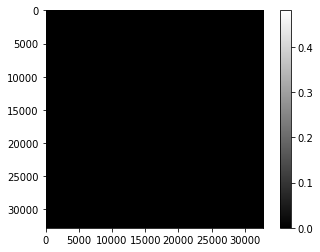

In [60]:
image_560Mhz_1000h = data_560Mhz_1000h[0].data[0,0]

plt.imshow(image_560Mhz_1000h, cmap='gray')
plt.colorbar()

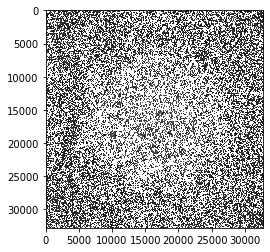

In [61]:
plt.imshow(image_560Mhz_1000h, cmap='gray', norm=LogNorm())